In [1]:
%load_ext autoreload
%autoreload 2 
%matplotlib nbagg
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
from functools import partial

os.environ['XLA_FLAGS']='--xla_gpu_cuda_data_dir=/gpfslocalsys/cuda/10.1.2'
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pickle
from skimage.metrics import peak_signal_noise_ratio as psnr
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except IndexError:
    pass

from nsec.datasets.fastmri import mri_noisy_generator
from nsec.mri.model import get_model

In [2]:
plt.rcParams['image.cmap'] = 'gray'

In [3]:
batch_size = 32
contrast = 'CORPD_FBK'
magnitude_images = True
noise_power_spec = 3*1e1
val_mri_gen = mri_noisy_generator(
    split='val',
    scale_factor=1e6,
    noise_power_spec=noise_power_spec,
    batch_size=batch_size,
    contrast=contrast,
    magnitude=magnitude_images,
    image_size=64,
)
##### BATCH DEFINITION
# (image_noisy, noise_power), noise_realisation
# here the noise_realisation is the full one, not the epsilon from the standard normal law

In [4]:
model, loss_fn, update, params, state, sn_state, opt_state, rng_seq = get_model(
    opt=False, 
    magnitude_images=True, 
    pad_crop=False,
    stride=False,
)

In [5]:
# Importing saved model
with open('../conv-dae-L2-mri-30.0_mag_no_stride_im64.pckl', 'rb') as file:
    params, state, sn_state = pickle.load(file)

In [6]:
score = partial(model.apply, params, state, next(rng_seq))

In [7]:
(x, s), su = next(val_mri_gen)
s = s[..., None, None, None]

In [8]:
%%time
res, state = score(x, s, is_training=False)

CPU times: user 4.22 s, sys: 2.85 s, total: 7.06 s
Wall time: 14.4 s


In [9]:
s

array([[[[-37.37894422]]],


       [[[ 29.85697339]]],


       [[[ 36.08994727]]],


       [[[ -7.07164774]]],


       [[[ 19.12876453]]],


       [[[-11.66702231]]],


       [[[  1.57331395]]],


       [[[-42.07183988]]],


       [[[ 49.24116984]]],


       [[[  8.9444271 ]]],


       [[[ -7.49746961]]],


       [[[ 23.90502981]]],


       [[[-33.75029447]]],


       [[[ -5.33951961]]],


       [[[ 22.03821417]]],


       [[[ -2.4516429 ]]],


       [[[-19.33218359]]],


       [[[  8.43986672]]],


       [[[ 11.18101128]]],


       [[[-11.59620616]]],


       [[[  0.96494193]]],


       [[[ 18.12069806]]],


       [[[ -3.53117735]]],


       [[[ 26.94626507]]],


       [[[ 43.93733918]]],


       [[[-10.12034513]]],


       [[[-33.97675621]]],


       [[[-12.17573695]]],


       [[[-39.64380641]]],


       [[[-33.11375112]]],


       [[[ 10.80087784]]],


       [[[ -8.93563368]]]])

<IPython.core.display.Javascript object>


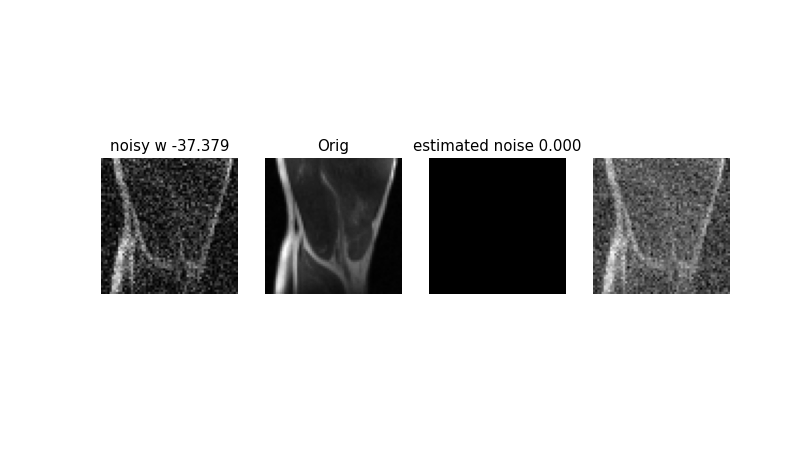

(-0.5, 63.5, 63.5, -0.5)

In [15]:
ind = 0
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(9, 5))
axs[0].set_title("noisy w %0.3f"%s[ind,0,0,0])
axs[0].imshow(jnp.abs(x)[ind,...,0],cmap='gray')
axs[0].axis('off')
axs[1].imshow(jnp.abs(x - su)[ind,...,0],cmap='gray')
axs[1].set_title('Orig')
axs[1].axis('off')
axs[2].imshow(res[ind,...,0],cmap='gray')
axs[2].axis('off')
axs[2].set_title("estimated noise %0.3f"%jnp.std(s[ind,:,:,0]**2 *res[ind,...,0]))
axs[3].imshow(x[ind,...,0] + s[ind,:,:,0]**2 * res[ind,...,0],cmap='gray')
axs[3].axis('off')

In [11]:
orig_images = x - su

In [12]:
psnrs = []
for gt_im, noise, pred_res, noisy_im in zip(orig_images, s, res, x):
    pred_im = np.squeeze(noisy_im + noise**2*pred_res)
    gt_im = np.squeeze(gt_im)
    psnrs.append(
        psnr(gt_im, pred_im, data_range=np.max(gt_im) - np.min(gt_im))
    )

In [13]:
np.mean(psnrs)

25.822866915214536